# Load community pipelines and components

## 1. Setup

- [PEFT](https://huggingface.co/docs/peft/index): PEFT(Parameter-Efficient Fine-Tuning)는 모델의 모든 파라미터를 미세 조정하는 것은 엄청난 비용이 들기 때문에 사전 학습된 대규모 모델을 다양한 다운스트림 애플리케이션에 효율적으로 적용하기 위한 라이브러리

- PEFT 방법은 소수의 (추가) 모델 파라미터만 미세 조정하여 계산 및 저장 비용을 크게 줄이면서도 완전히 미세 조정된 모델과 비슷한 성능을 제공

- LoRA 파일을 로딩할 때 사용

In [2]:
!pip install diffusers["torch"] transformers peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.4/183.4 kB 2.1 MB/s eta 0:00:00
  Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)


In [3]:
import torch
import transformers, diffusers
from diffusers import StableDiffusionPipeline
from diffusers import EulerDiscreteScheduler
from diffusers import AutoencoderKL

In [4]:
transformers.__version__, diffusers.__version__

('4.35.2', '0.26.3')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 모델 파일 다운로드

In [6]:
# 모델 파일
!gdown 1iOkmIPR1BGl58B8l1qgBGt3XhNri83-k

# vae 파일
!gdown 1iOo2ipgYDn21jyWBNkUhoC153VIIflJm

# text inversion 파일
!gdown 1iRTWTK7OawoYqAdEHtEDOQ0d8OYw21IU

# LoRA 파일
!gdown 1iLpT69LJ7UMi1oAygHEIcH9nFtEbYcKA

Downloading...
From (original): https://drive.google.com/uc?id=1iOkmIPR1BGl58B8l1qgBGt3XhNri83-k
From (redirected): https://drive.google.com/uc?id=1iOkmIPR1BGl58B8l1qgBGt3XhNri83-k&confirm=t&uuid=875048f2-62da-4afc-afdd-1b7c3ede50f7
To: /content/dantmix_v30.safetensors
100% 2.13G/2.13G [00:28<00:00, 74.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1iOo2ipgYDn21jyWBNkUhoC153VIIflJm
From (redirected): https://drive.google.com/uc?id=1iOo2ipgYDn21jyWBNkUhoC153VIIflJm&confirm=t&uuid=554a8642-5575-43bc-85bc-6b5bada6d7f0
To: /content/klF8Anime2VAE_klF8Anime2VAE.safetensors
100% 405M/405M [00:06<00:00, 62.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iRTWTK7OawoYqAdEHtEDOQ0d8OYw21IU
To: /content/easynegative.safetensors
100% 24.7k/24.7k [00:00<00:00, 60.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iLpT69LJ7UMi1oAygHEIcH9nFtEbYcKA
To: /content/SimzArts_LoRA.safetensors
100% 37.9M/37.9M [00:00<00:00, 135MB/s]


## 모델 로딩

- `pipeline`: 추가 구성 요소를 별도로 로딩하지 안은 기본 모델

- `pipeline_vae_euler`: 스케쥴러, 오토인코더, LoRA등 추가 구성요소를 로딩한 모델

- `pipeline_vae_euler`에 다양한 구성 요소를 로딩하는 실험을 하면서 결과에 미치는 영향을 조사

In [7]:
# https://civitai.com/models/243731/dantmix?modelVersionId=312265
repo_id = "./dantmix_v30.safetensors" # based on sd 1.5

pipeline = StableDiffusionPipeline.from_single_file(
    pretrained_model_link_or_path=repo_id,
    # 특정 vae를 쓸때 에러 날 수 있음
    # 같은 이유로 web-ui도 --no-half-vae 옵션이 있음
    # RuntimeError: Input type (struct c10::Half) and bias type (float) should be the same
    # 위 에러가 아니라면 이 옵션을 키면 속도가 빨라짐
    # torch_dtype=torch.float16
).to(device)

pipeline_vae_euler = StableDiffusionPipeline.from_single_file(
    pretrained_model_link_or_path=repo_id,
    # torch_dtype=torch.float16
).to(device)



config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers 

### 추가 구성요소 로딩

In [8]:
########################################################
# scheduler
# 스케쥴러 이름 설명
# https://www.reddit.com/r/StableDiffusion/comments/16wykzy/ever_wondered_what_those_cryptic_sampler_names/

pipeline_vae_euler.scheduler = EulerDiscreteScheduler.from_config(pipeline_vae_euler.scheduler.config)


########################################################
# vae
# https://civitai.com/models/23906/kl-f8-anime2-vae
# 손모양 약간 좋아짐
url = "klF8Anime2VAE_klF8Anime2VAE.safetensors"
vae = AutoencoderKL.from_single_file(url, from_tf=False).to(device)
pipeline_vae_euler.vae = vae


########################################################
# text inversion
# 이것들은 로딩해도 큰 차이가 없음
pipeline_vae_euler.load_textual_inversion("easynegative.safetensors")
# pipeline_vae_euler.load_textual_inversion("ng_deepnegative_v1_75t.pt")


########################################################
# lora, windows에서 peft 설치하면 안됨, 리눅스에서 실험해볼 필요있음
pipeline_vae_euler.load_lora_weights("SimzArts_LoRA.safetensors")
pipeline_vae_euler.fuse_lora(lora_scale=0.8)

## 프롬프트 세팅과 이미지 생성

In [9]:
# test seed number: 3107028957
# 손이 보정되는것이 확실히 확인됨
generator1 = torch.Generator(device="cuda").manual_seed(3107028957)
generator2 = torch.Generator(device="cuda").manual_seed(3107028957)

# https://civitai.com/images/5870711
prompt = "(masterpiece, best quality, ultra detailed, beautiful illustration), atmospheric perspective, depth of field, looking at viewer, beautiful detailed eyes, anime eyes:1.4, (cowboy shot), action pose, dynamic angle, warm smile, (outdoors, japanese architecture, torii gate, spring,), 1girl, mature woman, milf, curvy, cherry blossoms,"
negative_prompt = "(worst quality:1.4), (low quality:1.4), (monochrome:1.1), (extra fingers:2, deformed hands:2, polydactyl:2, physical defects:2, unhealthy deformed joints:2, unhealthy hands:2, physically abnormal:2, joint inequalities:2, limbs inequalities:2, 5 funny looking fingers:2), watermark, font, text, zombie, watermark, username, patreon username, patreon logo, censored, bar censor, bad-image-v2-39000, bad_prompt_version2-neg, sketch By bad artist, easynegative, ng_deepnegative_v1_75t, verybadimagenegative_v1.3,"

In [12]:
image1 = pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=1280, height=720,
    guidance_scale=20,
    num_inference_steps=25,
    generator=generator1,
).images[0]

image2 = pipeline_vae_euler(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=1280, height=720,
    guidance_scale=20,
    num_inference_steps=25,
    generator=generator2,
).images[0]


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

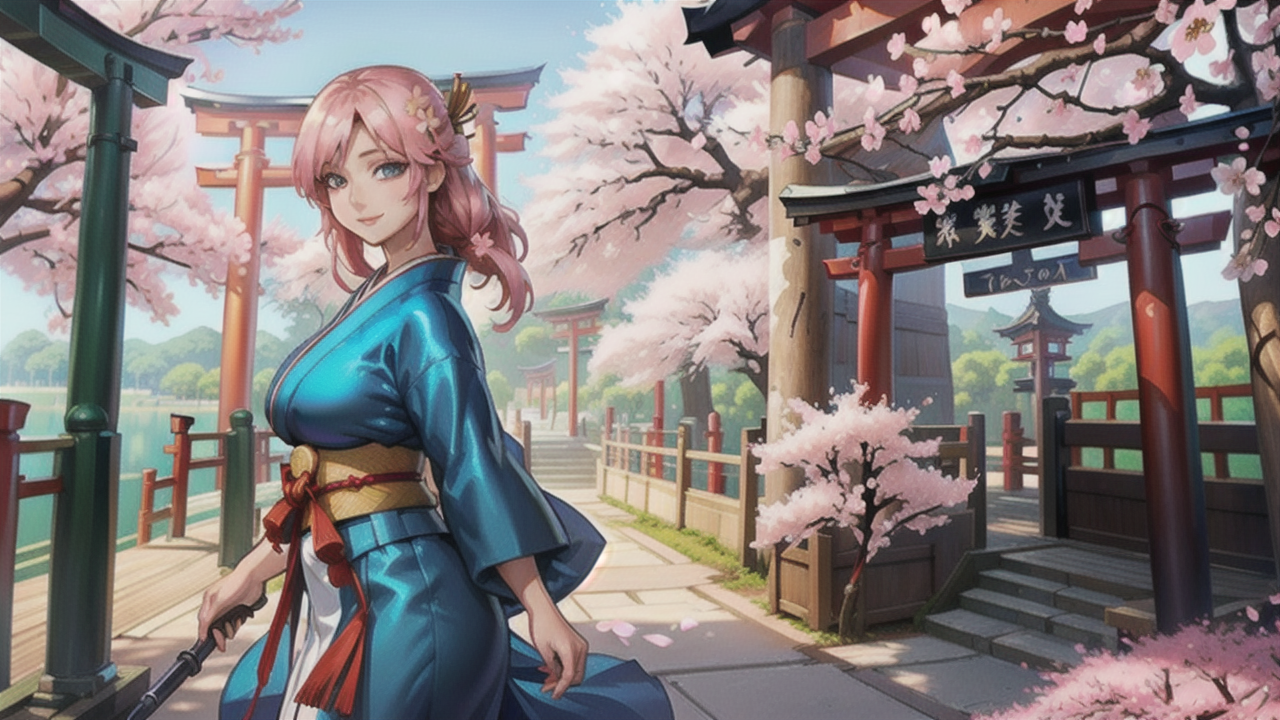

In [13]:
image1

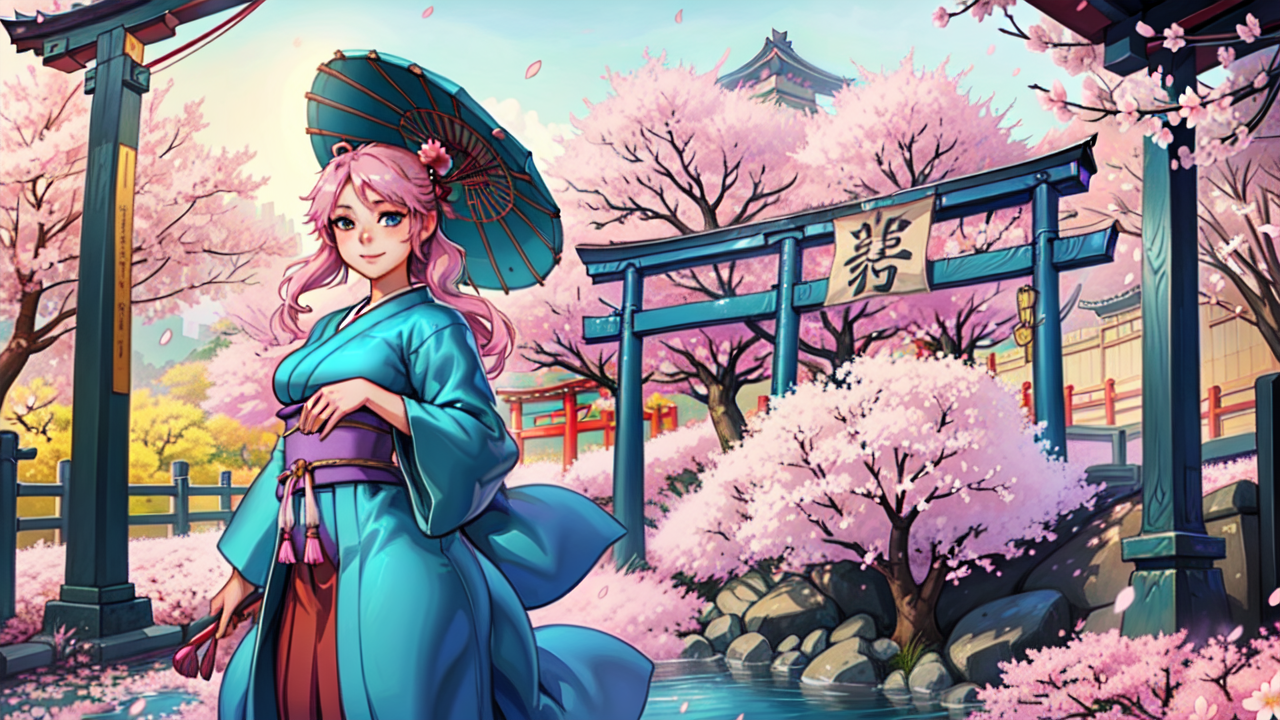

In [14]:
image2